In [1]:
# Cell 1
import pandas as pd

df=pd.read_csv('nutrition.dat',delim_whitespace=True)
df.columns
#df.head()

C:\Users\dougl\AppData\Local\Temp\ipykernel_3200\3241078444.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv('nutrition.dat',delim_whitespace=True)


Index(['FOOD', 'WT_GRAMS', 'PC_WATER', 'CALORIES', 'PROTEIN', 'FAT', 'SAT_FAT',
       'MONUNSAT', 'POLUNSAT', 'CHOLEST', 'CARBO', 'CALCIUM', 'PHOSPHOR',
       'IRON', 'POTASS', 'SODIUM', 'VIT_A_IU', 'VIT_A_RE', 'THIAMIN',
       'RIBOFLAV', 'NIACIN', 'ASCORBIC', 'CAL_GRAM', 'IRN_GRAM', 'PRO_GRAM',
       'FAT_GRAM'],
      dtype='object')

In [2]:
# Cell 2
# Python code for multiple regression model with all factors
import pandas as pd
import statsmodels.formula.api as sm

# clean up data frame
df.dropna() # drop missing values
model1 = sm.ols(formula='CALORIES~WT_GRAMS+PC_WATER+PROTEIN+FAT+SAT_FAT+MONUNSAT+POLUNSAT+CHOLEST+CARBO+CALCIUM+PHOSPHOR+IRON+POTASS+SODIUM+VIT_A_IU+VIT_A_RE+THIAMIN+RIBOFLAV+NIACIN+ASCORBIC+CAL_GRAM+IRN_GRAM+PRO_GRAM+FAT_GRAM',data=df)
fitted1 = model1.fit()
print(fitted1.summary())

                            OLS Regression Results                            
Dep. Variable:               CALORIES   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.962e+04
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:25:16   Log-Likelihood:                -3979.2
No. Observations:                 961   AIC:                             8008.
Df Residuals:                     936   BIC:                             8130.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -69.2779      6.937     -9.987      0.0

# Cell 3
## List factors that can be removed based upon p-values

MONUNSAT, POLUNSAT, CHOLEST, VIT_A_IU, VIT_A_RE, RIBOFLAV, NIACIN, ASCORBIC

In [3]:
# Cell 4
# Python code for fitting reduced multiple regression model

model2 = sm.ols(formula='CALORIES~WT_GRAMS+PC_WATER+PROTEIN+FAT+SAT_FAT+CARBO+CALCIUM+PHOSPHOR+IRON+POTASS+SODIUM+THIAMIN+CAL_GRAM+IRN_GRAM+PRO_GRAM+FAT_GRAM',data=df)
fitted2 = model2.fit()
print(fitted2.summary())

                            OLS Regression Results                            
Dep. Variable:               CALORIES   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.386e+04
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:25:16   Log-Likelihood:                -3987.0
No. Observations:                 961   AIC:                             8008.
Df Residuals:                     944   BIC:                             8091.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -69.4397      6.890    -10.078      0.0

In [4]:
# Cell 5
# Python code for prepAnovaTable for the full and reduced models found in cells 2 and 4

def prepANOVAtable(model):
    tmp={'Source':['Regression','Error','Total'],'df': [model.df_model,model.df_resid,model.df_model+model.df_resid],'Sum of Squares':[model.ssr,model.ess,model.ssr+model.ess],'Mean Square':[model.mse_model,model.mse_resid,model.mse_total],'F Statistic':[model.fvalue,'',''],'p value':[model.f_pvalue,'','']}
    anova_df=pd.DataFrame(data=tmp)
    anova_df=anova_df[['Source','df','Sum of Squares','Mean Square','F Statistic','p value']]
    return(anova_df)
    
print("full model")
anova_full_df=prepANOVAtable(fitted1)
print(anova_full_df)
print("reduced model")
anova_reduced_df=prepANOVAtable(fitted2)
print(anova_reduced_df)


full model
       Source     df  Sum of Squares   Mean Square   F Statistic p value
0  Regression   24.0    2.222205e+05  1.178111e+07  49622.420698     0.0
1       Error  936.0    2.827467e+08  2.374151e+02                      
2       Total  960.0    2.829689e+08  2.947593e+05                      
reduced model
       Source     df  Sum of Squares   Mean Square   F Statistic p value
0  Regression   16.0    2.258455e+05  1.767144e+07  73863.948304     0.0
1       Error  944.0    2.827430e+08  2.392431e+02                      
2       Total  960.0    2.829689e+08  2.947593e+05                      


In [5]:
# Cell 6 changed to code
## Conduct a partial F-test
from scipy.stats import f


# Compute the partial F-test
rss_full = fitted1.ssr  # Residual sum of squares for full model
rss_reduced = fitted2.ssr  # Residual sum of squares for reduced model

n = model1.nobs  # Number of observations
p_full = len(fitted1.params)-1  # Number of predictors in the full model (including intercept)
p_reduced = len(fitted2.params)-1  # Number of predictors in the reduced model (including intercept)

df_numerator = p_full - p_reduced  # Degrees of freedom for the numerator
df_denominator = n - p_full  # Degrees of freedom for the denominator

f_statistic = ((rss_reduced - rss_full) / df_numerator) / (rss_full / df_denominator)

# Calculate the p-value
p_value = 1 - f.cdf(f_statistic, df_numerator, df_denominator)

# Print the results
print("Partial F-Test Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("The additional predictors in the full model significantly improve the model fit.")
else:
    print("The additional predictors in the full model do not significantly improve the model fit.")



Partial F-Test Results:
F-statistic: 1.9106
p-value: 0.0552
The additional predictors in the full model do not significantly improve the model fit.


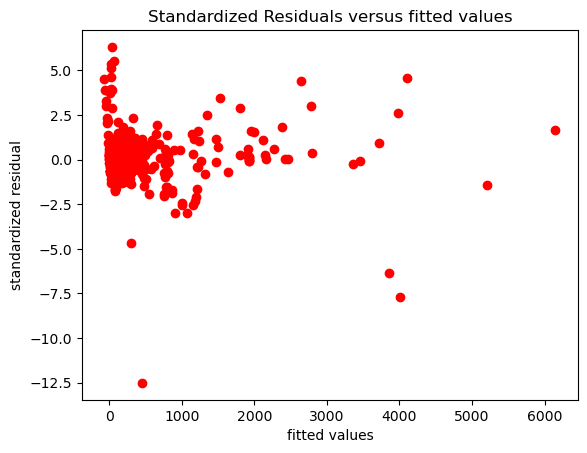

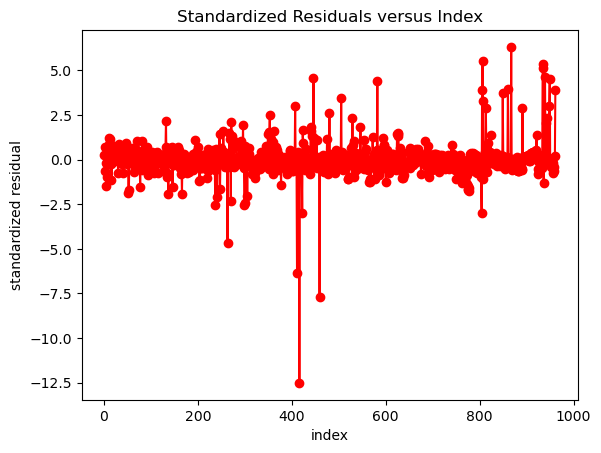

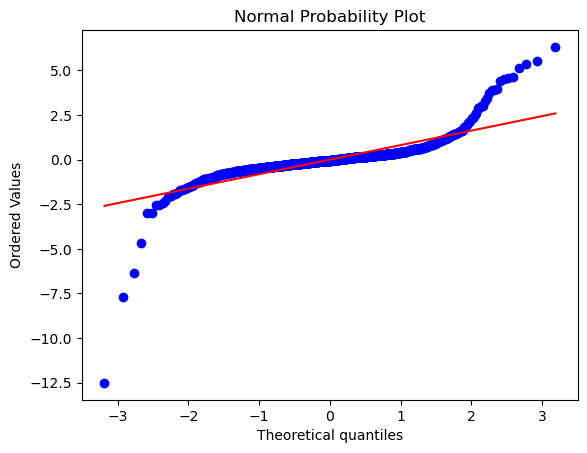

ideally there would be residuals plots for each of the terms in the model and those terms not in the model also. That is too many plots for this solution.


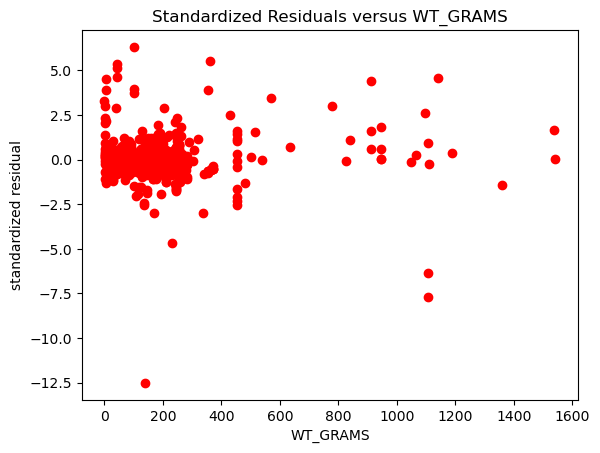

In [6]:
# Cell 7
# Python code for residual analysis of reduced model
import matplotlib.pyplot as plt

residual2=fitted2.resid_pearson
fittedValues=fitted2.fittedvalues
plt.plot(fittedValues, residual2, 'ro')
plt.xlabel('fitted values')
plt.ylabel('standardized residual')
plt.title('Standardized Residuals versus fitted values')
plt.show()

import numpy as np

id=np.arange(1,df["CALORIES"].size+1,1)
plt.plot(id,residual2,'-ro')
plt.xlabel('index')
plt.ylabel('standardized residual')
plt.title('Standardized Residuals versus Index')
plt.show()

from scipy import stats
# normal probability plot
stats.probplot(residual2, plot=plt)
plt.title('Normal Probability Plot')
plt.show()

plt.plot(df["WT_GRAMS"], residual2, 'ro')
plt.xlabel('WT_GRAMS')
plt.ylabel('standardized residual')
plt.title('Standardized Residuals versus WT_GRAMS')

print("ideally there would be residuals plots for each of the terms in the model and those terms not in the model also. That is too many plots for this solution.")

# Cell 8
## Interpret the results of the residual analysis

**The data is a mess. There are a lot of outliers and the residuals do not appear to be normallly distributed.**

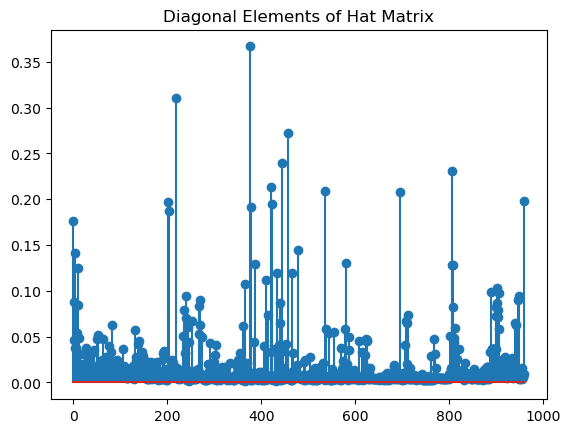

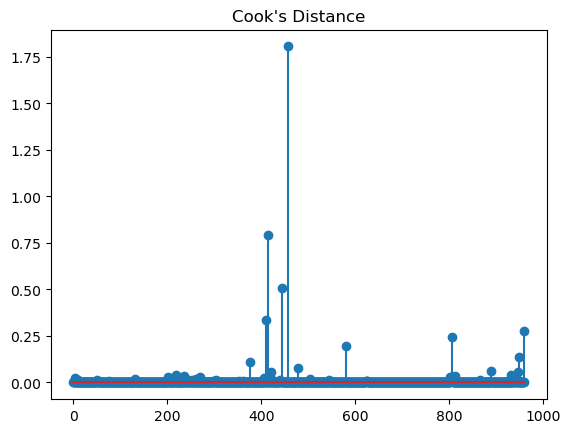

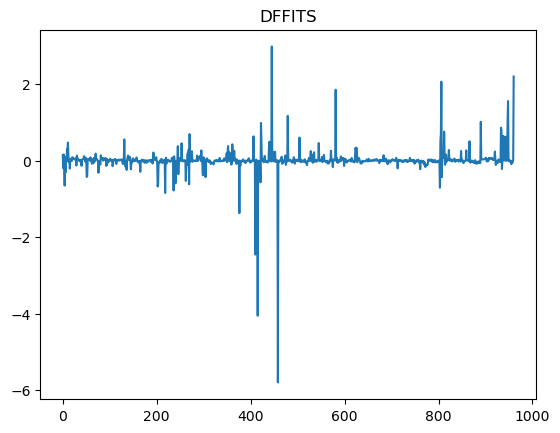

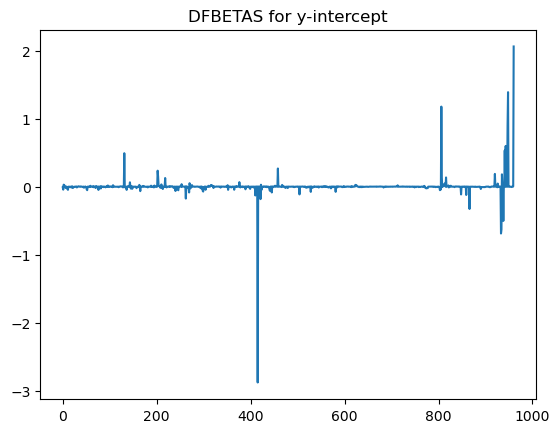

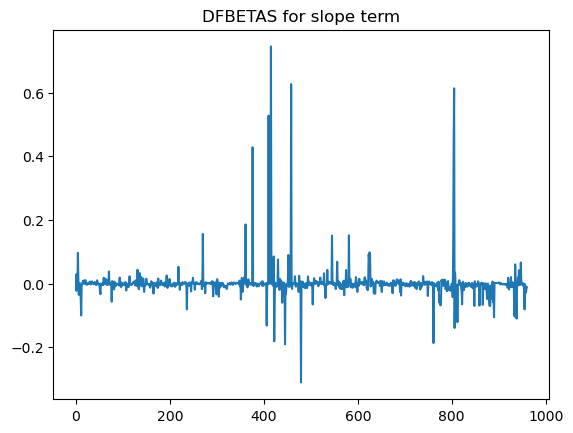

In [7]:
# Cell 9
# Python code to identify high-leverage and influential points

from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(fitted2)
plt.stem(np.arange(len(test_class.hat_matrix_diag)),test_class.hat_matrix_diag)
plt.title('Diagonal Elements of Hat Matrix')
plt.show()

plt.stem(np.arange(len(test_class.cooks_distance[0])),test_class.cooks_distance[0])
plt.title("Cook's Distance")
plt.show()

plt.plot(np.arange(len(test_class.dffits[0])),test_class.dffits[0])
plt.title("DFFITS")
plt.show()

betas=np.array(test_class.dfbetas)
betas[:,0]
plt.plot(np.arange(len(betas[:,0])),betas[:,0])
plt.title("DFBETAS for y-intercept")
plt.show()

betas=np.array(test_class.dfbetas)
betas[:,1]
plt.plot(np.arange(len(betas[:,1])),betas[:,1])
plt.title("DFBETAS for slope term")
plt.show()

# Cell 10
## List high-leverage and influential points

**There are almost too many to list.**

In [8]:
# Cell 11
# Python code to perform forward selection of all factors
import statsmodels.formula.api as smf

def forward_selection(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

df_reduced=df.drop(columns=['FOOD'])
df_reduced.head()
forward=forward_selection(df_reduced,'CALORIES')
print(forward.model.formula)
print(forward.rsquared)
print(forward.rsquared_adj)

CALORIES ~ CARBO + FAT + PROTEIN + POTASS + WT_GRAMS + THIAMIN + IRON + PHOSPHOR + CALCIUM + FAT_GRAM + CAL_GRAM + PC_WATER + SODIUM + IRN_GRAM + PRO_GRAM + POLUNSAT + ASCORBIC + CHOLEST + 1
0.9992092224548882
0.999194112055937


# Cell 12
## Best model found using forward selection

In [9]:
# Cell 13
# Python code to perform backwards selection of all factors
import statsmodels.api as sm

def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        model = sm.OLS(y, sm.add_constant(X[features])).fit()
        p_values = model.pvalues.iloc[1:]  # Ignore the intercept's p-value
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features
#
y = df_reduced['CALORIES']
#print(y)
X = df_reduced
X=X.drop(columns=['CALORIES'])
#print(X)
#print(X)
#print(y)
best_features = backward_elimination(X, y)
print("Selected features:", best_features)

Selected features: ['WT_GRAMS', 'PC_WATER', 'PROTEIN', 'FAT', 'CARBO', 'CALCIUM', 'PHOSPHOR', 'IRON', 'POTASS', 'SODIUM', 'THIAMIN', 'CAL_GRAM', 'IRN_GRAM', 'PRO_GRAM', 'FAT_GRAM']


# Cell 14
## Best model found using backwards selection

In [10]:
# Cell 15
# Python code to perform stepwise selection of all factors

def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05):
    """ Perform a stepwise regression.
    Args:
        X - pandas DataFrame with candidate features
        y - list-like with the dependent variable
        initial_list - list of features to start with (default is empty)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
    Returns:
        list of selected features
    """
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            print(f'Add  {best_feature} with p-value {best_pval:.6}')

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # all except intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            print(f'Remove {worst_feature} with p-value {worst_pval:.6}')

        if not changed:
            break

    return included
#
best_features = stepwise_selection(X, y)
print("Selected features:", best_features)

Add  CARBO with p-value 9.81042e-314
Add  MONUNSAT with p-value 0.0
Add  FAT with p-value 0.0
Remove MONUNSAT with p-value 0.442206
Add  PROTEIN with p-value 1.34556e-307
Add  POTASS with p-value 1.78952e-34
Add  WT_GRAMS with p-value 6.6246e-12
Add  THIAMIN with p-value 3.21941e-09
Add  IRON with p-value 7.84632e-11
Add  PHOSPHOR with p-value 0.000202272
Add  CALCIUM with p-value 8.69358e-05
Add  FAT_GRAM with p-value 0.0142367
Add  CAL_GRAM with p-value 6.76354e-05
Add  PC_WATER with p-value 7.11164e-19
Add  SODIUM with p-value 0.000494646
Add  IRN_GRAM with p-value 0.0158821
Add  PRO_GRAM with p-value 0.0177605
Add  POLUNSAT with p-value 0.0213648
Selected features: ['CARBO', 'FAT', 'PROTEIN', 'POTASS', 'WT_GRAMS', 'THIAMIN', 'IRON', 'PHOSPHOR', 'CALCIUM', 'FAT_GRAM', 'CAL_GRAM', 'PC_WATER', 'SODIUM', 'IRN_GRAM', 'PRO_GRAM', 'POLUNSAT']


# Cell 16
## Best model found using stepwise selection

In [11]:
# Cell 17
# Python code to perform all subsets selection.

import itertools
#
def best_subsets_selection(X, y):
    """Perform best subsets regression and return the best model based on AIC, BIC, and Adjusted R²."""
    n = len(X)  # number of observations
    all_features = X.columns.tolist()
    
    # Store results for each subset
    results = []
    
    # Loop over all possible subsets of features
    for k in range(1, len(all_features) + 1):
        for combo in itertools.combinations(all_features, k):
            combo = list(combo)
            X_subset = sm.add_constant(X[combo])
            model = sm.OLS(y, X_subset).fit()
            
            # Store the adjusted R², AIC, and BIC for each subset
            results.append({
                'features': combo,
                'adjusted_r2': model.rsquared_adj,
                'AIC': model.aic,
                'BIC': model.bic
            })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Get the models with the best adjusted R², AIC, and BIC
    best_adj_r2_model = results_df.loc[results_df['adjusted_r2'].idxmax()]
    best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
    best_bic_model = results_df.loc[results_df['BIC'].idxmin()]
    
    return best_adj_r2_model, best_aic_model, best_bic_model
#
best_adj_r2_model, best_aic_model, best_bic_model = best_subsets_selection(X, y)

print("Best model based on adjusted R²:", best_adj_r2_model)
print("Best model based on AIC:", best_aic_model)
print("Best model based on BIC:", best_bic_model)

Best model based on adjusted R²: features       [WT_GRAMS, PC_WATER, PROTEIN, FAT, SAT_FAT, MO...
adjusted_r2                                             0.999196
AIC                                                  8003.356498
BIC                                                  8110.451935
Name: 16775008, dtype: object
Best model based on AIC: features       [WT_GRAMS, PC_WATER, PROTEIN, FAT, SAT_FAT, MO...
adjusted_r2                                             0.999196
AIC                                                  8002.433968
BIC                                                   8104.66143
Name: 16764466, dtype: object
Best model based on BIC: features       [WT_GRAMS, PC_WATER, PROTEIN, FAT, CARBO, CALC...
adjusted_r2                                             0.999179
AIC                                                  8016.326732
BIC                                                  8084.478374
Name: 9897286, dtype: object


# Cell 18
## Best model found using all subsets selection

# Cell 19
## Summarize the models found using the different selection techniques and pick a best model